In [2]:
# for mounting drive with google colabs
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!pip install -q keras

In [5]:
!ls

datalab  drive


In [0]:
import sys
import time 
import os
import cv2
import datetime
from PIL import Image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
% matplotlib inline

# Reading data

In [0]:
data = pd.read_csv('drive/fer2013.csv')

In [8]:
data['Usage'].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [0]:
data_train = data.loc[data['Usage']=='Training']
public_test = data.loc[data['Usage']=='PublicTest']
private_test = data.loc[data['Usage']=='PrivateTest']

In [10]:
data_train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
public_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [12]:
private_test.head()

,emotion,pixels,Usage
32298,0,170 118 101 88 88 75 78 82 66 74 68 59 63 64 6...,PrivateTest
32299,5,7 5 8 6 7 3 2 6 5 4 4 5 7 5 5 5 6 7 7 7 10 10 ...,PrivateTest
32300,6,232 240 241 239 237 235 246 117 24 24 22 13 12...,PrivateTest
32301,4,200 197 149 139 156 89 111 58 62 95 113 117 11...,PrivateTest
32302,2,40 28 33 56 45 33 31 78 152 194 200 186 196 20...,PrivateTest


In [13]:
data_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [0]:
k = data_train.iloc[1,1]

In [15]:
len(k.split())

2304

# Data Preprocessing
## Transforming csv to understandable image data

In [0]:
from sklearn.utils import shuffle
data_train = shuffle(data_train)
public_test = shuffle(public_test)
private_test = shuffle(private_test)

In [17]:
train = np.array(data_train.iloc[:,1])
validation = np.array(private_test.iloc[:,1])
test = np.array(public_test.iloc[:,1])
print(train.shape, test.shape, validation.shape)

(28709,) (3589,) (3589,)


In [0]:
train = train.reshape(28709,1)
test = test.reshape(3589,1)
validation = validation.reshape(3589,1)
X_train_flip = list()

In [19]:
train.shape

(28709, 1)

In [0]:
def data_augmentation(img):
  img = cv2.flip(img.reshape(48,48), 1)
  return np.array(img.reshape(48,48,1)).astype(np.float32)

In [0]:
def reform_data_aug(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)

  X_train_flip.append(data_augmentation(t3))
  return t3

In [0]:
def reform_data(img_str):
  t1 = img_str[0].split()
  t2 = np.array(t1).astype(np.float32)
  t3 = t2.reshape(48, 48, 1)
  return t3

In [0]:
X_train_1 = np.apply_along_axis(reform_data_aug, 1, train)
X_test = np.apply_along_axis(reform_data, 1, test)
X_validation = np.apply_along_axis(reform_data, 1, validation)

In [24]:
np.array(X_train_flip).shape

(28709, 48, 48, 1)

In [25]:
X_train = np.array(list(X_train_1) + X_train_flip)
print(X_train.shape)

(57418, 48, 48, 1)


In [26]:
print(X_train.shape, X_test.shape, X_validation.shape)

(57418, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1)


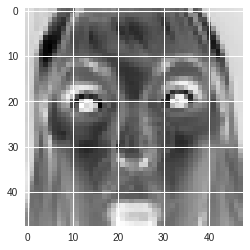

In [27]:
# Sample image
plt.imshow(X_train[0].reshape(48,48))

### Normalization 

In [0]:
X_train = X_train/255
X_test = X_test/255
X_validation = X_validation/255

### One Hot Encoding

In [0]:
Y_train = data_train['emotion']
Y_test = public_test['emotion']
Y_validation = private_test['emotion']

In [30]:
print(Y_train.shape, Y_test.shape, Y_validation.shape)

(28709,) (3589,) (3589,)


In [0]:
def onehot(Y, C):
  Y = np.eye(C)[Y].T
  return Y

In [32]:
data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [0]:
Y_test = onehot(Y_test, 7).T
Y_train = onehot(Y_train, 7).T
Y_valid = onehot(Y_validation, 7).T

In [34]:
Y_train.shape

(28709, 7)

In [0]:
Y_train = np.array(list(Y_train) + list(Y_train))

In [36]:
Y_train.shape

(57418, 7)

In [0]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=2)

In [38]:
print(X_validation.shape, Y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


In [0]:
# Clear memory
del data
del data_train
del public_test
del private_test
del Y_validation

## CNN Models
Taking 3 - 4 models for ensemble voting

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2

Using TensorFlow backend.


### 1-Basic 5 layer model

In [0]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
input_shape = (48, 48, 1)

In [0]:
def Model1(input_shape=(48,48,1)):
  model = Sequential()
  
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=input_shape, data_format='channels_last', kernel_regularizer=l2(0.01)))
  model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(2*2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*2*num_features, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2*num_features, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(num_labels, activation='softmax'))
  return model

In [43]:
model1 = Model1()
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)       512       
__________

In [0]:
model1.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard = TensorBoard(log_dir='./logs')
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model1.load_weights("drive/face_expr_model1.h5")

In [47]:
model1.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=300,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, tensorboard, checkpointer])

Train on 57418 samples, validate on 3589 samples
Epoch 1/300
43840/57418 [=====================>........] - ETA: 27s - loss: 0.3085 - acc: 0.8987

57418/57418 [==============================] - 120s 2ms/step - loss: 0.3182 - acc: 0.8963 - val_loss: 1.2731 - val_acc: 0.6709

Epoch 00001: val_loss improved from inf to 1.27313, saving model to /drive
Epoch 2/300
17408/57418 [========>.....................] - ETA: 1:19 - loss: 0.3355 - acc: 0.8915

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3466 - acc: 0.8868 - val_loss: 1.2974 - val_acc: 0.6489

Epoch 00002: val_loss did not improve from 1.27313
Epoch 3/300
10944/57418 [====>.........................] - ETA: 1:32 - loss: 0.3368 - acc: 0.8865

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3456 - acc: 0.8844 - val_loss: 1.3302 - val_acc: 0.6559

Epoch 00003: val_loss did not improve from 1.27313
Epoch 4/300
 8896/57418 [===>..........................] - ETA: 1:36 - loss: 0.3441 - acc: 0.8853

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3552 - acc: 0.8833 - val_loss: 1.2190 - val_acc: 0.6620

Epoch 00004: val_loss improved from 1.27313 to 1.21900, saving model to /drive
Epoch 5/300
 7488/57418 [==>...........................] - ETA: 1:40 - loss: 0.3480 - acc: 0.8868

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3649 - acc: 0.8793 - val_loss: 1.3062 - val_acc: 0.6601

Epoch 00005: val_loss did not improve from 1.21900
Epoch 6/300
 7872/57418 [===>..........................] - ETA: 1:39 - loss: 0.4933 - acc: 0.8368

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3878 - acc: 0.8713 - val_loss: 1.2542 - val_acc: 0.6704

Epoch 00006: val_loss did not improve from 1.21900
Epoch 7/300
 8000/57418 [===>..........................] - ETA: 1:38 - loss: 0.3756 - acc: 0.8776

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3630 - acc: 0.8800 - val_loss: 1.3386 - val_acc: 0.6592

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 00007: val_loss did not improve from 1.21900
Epoch 8/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.4050 - acc: 0.8674

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3581 - acc: 0.8812 - val_loss: 1.2405 - val_acc: 0.6634

Epoch 00008: val_loss did not improve from 1.21900
Epoch 9/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3625 - acc: 0.8836

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3454 - acc: 0.8872 - val_loss: 1.2977 - val_acc: 0.6565

Epoch 00009: val_loss did not improve from 1.21900
Epoch 10/300
 7808/57418 [===>..........................] - ETA: 1:39 - loss: 0.3410 - acc: 0.8922

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3412 - acc: 0.8890 - val_loss: 1.3018 - val_acc: 0.6581

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 00010: val_loss did not improve from 1.21900
Epoch 11/300
 6144/57418 [==>...........................] - ETA: 1:42 - loss: 0.3206 - acc: 0.8910

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3303 - acc: 0.8903 - val_loss: 1.2574 - val_acc: 0.6665

Epoch 00011: val_loss did not improve from 1.21900
Epoch 12/300
 7424/57418 [==>...........................] - ETA: 1:40 - loss: 0.3074 - acc: 0.8994

57418/57418 [==============================] - 117s 2ms/step - loss: 0.3177 - acc: 0.8942 - val_loss: 1.3263 - val_acc: 0.6701

Epoch 00012: val_loss did not improve from 1.21900
Epoch 00012: early stopping


In [0]:
model1.save_weights("drive/face_expr_model1.h5")

In [48]:
model1.evaluate(X_test, Y_test, batch_size=batch_size)


3589/3589 [==============================] - 2s 695us/step


[1.3717110243372415, 0.670660351076874]

### 2- Model2 - https://arxiv.org/pdf/1706.01509

In [0]:
def Model2(input_shape=(48,48,1)):
  model = Sequential()
  model.add(Conv2D(10, (5,5), activation='relu', kernel_regularizer=l2(0.01), input_shape=input_shape))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (5,5), activation='relu'))
  model.add(MaxPooling2D())
#   model.add(Dropout(0.5))
  model.add(Conv2D(10, (3,3), activation='relu'))
  model.add(MaxPooling2D()) 
#   model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_labels, activation='softmax'))
  return model

In [51]:
model2 = Model2()
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 44, 44, 10)        260       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 10)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 18, 10)        2510      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 10)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 10)          910       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 10)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 90)                0         
__________

In [0]:
lr_reducer2 = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
tensorboard2 = TensorBoard(log_dir='./logs')
early_stopper2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpointer2 = ModelCheckpoint("/drive", monitor='val_loss', verbose=1, save_best_only=True)

In [0]:
model2.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [0]:
model2.load_weights("drive/face_expr_model2.h5")

In [0]:
model2.fit(X_train,Y_train,
          batch_size=batch_size,
          epochs=500,
          verbose=1,
          validation_data=(X_validation, Y_valid),
          shuffle=True,
          callbacks=[lr_reducer2, tensorboard2, checkpointer2])

Train on 57418 samples, validate on 3589 samples
Epoch 1/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5969 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00001: val_loss did not improve from 1.21309
Epoch 2/500
50816/57418 [=========================>....] - ETA: 1s - loss: 1.0611 - acc: 0.5987

57418/57418 [==============================] - 13s 221us/step - loss: 1.0620 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00002: val_loss did not improve from 1.21309
Epoch 3/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00003: val_loss did not improve from 1.21309
Epoch 4/500
18880/57418 [========>.....................] - ETA: 8s - loss: 1.0741 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0644 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00004: ReduceLROnPlateau reducing learning rate to 3.426607435297324e-12.

Epoch 00004: val_loss did not improve from 1.21309
Epoch 5/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00005: val_loss did not improve from 1.21309
Epoch 6/500
 2880/57418 [>.............................] - ETA: 12s - loss: 1.0792 - acc: 0.5938

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00006: val_loss did not improve from 1.21309
Epoch 7/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0614 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.0839467698301484e-12.

Epoch 00007: val_loss did not improve from 1.21309
Epoch 8/500
 9024/57418 [===>..........................] - ETA: 10s - loss: 1.0601 - acc: 0.5961

57418/57418 [==============================] - 13s 221us/step - loss: 1.0617 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00008: val_loss did not improve from 1.21309
Epoch 9/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0618 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00009: val_loss did not improve from 1.21309
Epoch 10/500
11520/57418 [=====>........................] - ETA: 9s - loss: 1.0641 - acc: 0.5943 

57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00010: ReduceLROnPlateau reducing learning rate to 2.775552053815855e-12.

Epoch 00010: val_loss did not improve from 1.21309
Epoch 11/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00011: val_loss did not improve from 1.21309
Epoch 12/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0690 - acc: 0.5875

57418/57418 [==============================] - 13s 224us/step - loss: 1.0611 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00012: val_loss did not improve from 1.21309
Epoch 13/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0619 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00013: ReduceLROnPlateau reducing learning rate to 2.497996926496826e-12.

Epoch 00013: val_loss did not improve from 1.21309
Epoch 14/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0569 - acc: 0.6001

57418/57418 [==============================] - 13s 225us/step - loss: 1.0583 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00014: val_loss did not improve from 1.21309
Epoch 15/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00015: val_loss did not improve from 1.21309
Epoch 16/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0755 - acc: 0.5975

57418/57418 [==============================] - 13s 225us/step - loss: 1.0635 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.248197331425339e-12.

Epoch 00016: val_loss did not improve from 1.21309
Epoch 17/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0603 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00017: val_loss did not improve from 1.21309
Epoch 18/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0526 - acc: 0.6038

57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00018: val_loss did not improve from 1.21309
Epoch 19/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00019: ReduceLROnPlateau reducing learning rate to 2.023377559251527e-12.

Epoch 00019: val_loss did not improve from 1.21309
Epoch 20/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0488 - acc: 0.6052

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00020: val_loss did not improve from 1.21309
Epoch 21/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0628 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00021: val_loss did not improve from 1.21309
Epoch 22/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5960

57418/57418 [==============================] - 13s 224us/step - loss: 1.0595 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.8210398033263743e-12.

Epoch 00022: val_loss did not improve from 1.21309
Epoch 23/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0606 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00023: val_loss did not improve from 1.21309
Epoch 24/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0411 - acc: 0.6064

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00024: val_loss did not improve from 1.21309
Epoch 25/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0609 - acc: 0.5956 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.638935862025015e-12.

Epoch 00025: val_loss did not improve from 1.21309
Epoch 26/500
 8384/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.5980

57418/57418 [==============================] - 13s 223us/step - loss: 1.0549 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00026: val_loss did not improve from 1.21309
Epoch 27/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0571 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00027: val_loss did not improve from 1.21309
Epoch 28/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0624 - acc: 0.6025

57418/57418 [==============================] - 13s 223us/step - loss: 1.0596 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.4750422563068744e-12.

Epoch 00028: val_loss did not improve from 1.21309
Epoch 29/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00029: val_loss did not improve from 1.21309
Epoch 30/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0670 - acc: 0.6034

57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00030: val_loss did not improve from 1.21309
Epoch 31/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.3275380794652846e-12.

Epoch 00031: val_loss did not improve from 1.21309
Epoch 32/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0440 - acc: 0.6077

57418/57418 [==============================] - 13s 222us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00032: val_loss did not improve from 1.21309
Epoch 33/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0583 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00033: val_loss did not improve from 1.21309
Epoch 34/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0417 - acc: 0.6051

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1.1947843105500345e-12.

Epoch 00034: val_loss did not improve from 1.21309
Epoch 35/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0629 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00035: val_loss did not improve from 1.21309
Epoch 36/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0427 - acc: 0.5893

57418/57418 [==============================] - 13s 221us/step - loss: 1.0611 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00036: val_loss did not improve from 1.21309
Epoch 37/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0628 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1.0753058599793919e-12.

Epoch 00037: val_loss did not improve from 1.21309
Epoch 38/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0696 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00038: val_loss did not improve from 1.21309
Epoch 39/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0613 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00039: val_loss did not improve from 1.21309
Epoch 40/500
11200/57418 [====>.........................] - ETA: 9s - loss: 1.0476 - acc: 0.6029 

57418/57418 [==============================] - 13s 219us/step - loss: 1.0577 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00040: ReduceLROnPlateau reducing learning rate to 9.677752739814527e-13.

Epoch 00040: val_loss did not improve from 1.21309
Epoch 41/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0596 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00041: val_loss did not improve from 1.21309
Epoch 42/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0802 - acc: 0.5988

57418/57418 [==============================] - 13s 226us/step - loss: 1.0598 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00042: val_loss did not improve from 1.21309
Epoch 43/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0604 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00043: ReduceLROnPlateau reducing learning rate to 8.709977075520293e-13.

Epoch 00043: val_loss did not improve from 1.21309
Epoch 44/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0722 - acc: 0.5962

57418/57418 [==============================] - 13s 223us/step - loss: 1.0629 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00044: val_loss did not improve from 1.21309
Epoch 45/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0573 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00045: val_loss did not improve from 1.21309
Epoch 46/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0446 - acc: 0.6083

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00046: ReduceLROnPlateau reducing learning rate to 7.838979465546459e-13.

Epoch 00046: val_loss did not improve from 1.21309
Epoch 47/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0580 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00047: val_loss did not improve from 1.21309
Epoch 48/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0603 - acc: 0.5908

57418/57418 [==============================] - 13s 223us/step - loss: 1.0615 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00048: val_loss did not improve from 1.21309
Epoch 49/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0610 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00049: ReduceLROnPlateau reducing learning rate to 7.055081616570008e-13.

Epoch 00049: val_loss did not improve from 1.21309
Epoch 50/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0677 - acc: 0.6035

57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.6015 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00050: val_loss did not improve from 1.21309
Epoch 51/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00051: val_loss did not improve from 1.21309
Epoch 52/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0598 - acc: 0.5988

57418/57418 [==============================] - 13s 227us/step - loss: 1.0618 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00052: ReduceLROnPlateau reducing learning rate to 6.349573210967519e-13.

Epoch 00052: val_loss did not improve from 1.21309
Epoch 53/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00053: val_loss did not improve from 1.21309
Epoch 54/500
 1600/57418 [..............................] - ETA: 12s - loss: 1.0627 - acc: 0.5944

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00054: val_loss did not improve from 1.21309
Epoch 55/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00055: ReduceLROnPlateau reducing learning rate to 5.714615792292571e-13.

Epoch 00055: val_loss did not improve from 1.21309
Epoch 56/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0587 - acc: 0.6004

57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5971 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00056: val_loss did not improve from 1.21309
Epoch 57/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00057: val_loss did not improve from 1.21309
Epoch 58/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0501 - acc: 0.6007

57418/57418 [==============================] - 13s 222us/step - loss: 1.0591 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00058: ReduceLROnPlateau reducing learning rate to 5.143154457008803e-13.

Epoch 00058: val_loss did not improve from 1.21309
Epoch 59/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0619 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00059: val_loss did not improve from 1.21309
Epoch 60/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0469 - acc: 0.5885

57418/57418 [==============================] - 13s 221us/step - loss: 1.0585 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00060: val_loss did not improve from 1.21309
Epoch 61/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0641 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00061: ReduceLROnPlateau reducing learning rate to 4.628838816151531e-13.

Epoch 00061: val_loss did not improve from 1.21309
Epoch 62/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0435 - acc: 0.6070

57418/57418 [==============================] - 13s 221us/step - loss: 1.0609 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00062: val_loss did not improve from 1.21309
Epoch 63/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0628 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00063: val_loss did not improve from 1.21309
Epoch 64/500
11264/57418 [====>.........................] - ETA: 10s - loss: 1.0670 - acc: 0.5945

57418/57418 [==============================] - 13s 222us/step - loss: 1.0623 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00064: ReduceLROnPlateau reducing learning rate to 4.1659546905908895e-13.

Epoch 00064: val_loss did not improve from 1.21309
Epoch 65/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00065: val_loss did not improve from 1.21309
Epoch 66/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0881 - acc: 0.6039

57418/57418 [==============================] - 13s 225us/step - loss: 1.0613 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00066: val_loss did not improve from 1.21309
Epoch 67/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0589 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00067: ReduceLROnPlateau reducing learning rate to 3.7493592215318006e-13.

Epoch 00067: val_loss did not improve from 1.21309
Epoch 68/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0479 - acc: 0.6045

57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00068: val_loss did not improve from 1.21309
Epoch 69/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00069: val_loss did not improve from 1.21309
Epoch 70/500
11200/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.5946

57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00070: ReduceLROnPlateau reducing learning rate to 3.3744232993786204e-13.

Epoch 00070: val_loss did not improve from 1.21309
Epoch 71/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0619 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00071: val_loss did not improve from 1.21309
Epoch 72/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0578 - acc: 0.6124

57418/57418 [==============================] - 13s 224us/step - loss: 1.0627 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00072: val_loss did not improve from 1.21309
Epoch 73/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0589 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00073: ReduceLROnPlateau reducing learning rate to 3.036981067018954e-13.

Epoch 00073: val_loss did not improve from 1.21309
Epoch 74/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0618 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0586 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00074: val_loss did not improve from 1.21309
Epoch 75/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0610 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00075: val_loss did not improve from 1.21309
Epoch 76/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5913

57418/57418 [==============================] - 13s 224us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00076: ReduceLROnPlateau reducing learning rate to 2.7332828383443144e-13.

Epoch 00076: val_loss did not improve from 1.21309
Epoch 77/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0592 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00077: val_loss did not improve from 1.21309
Epoch 78/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0542 - acc: 0.6029

57418/57418 [==============================] - 13s 224us/step - loss: 1.0575 - acc: 0.6003 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00078: val_loss did not improve from 1.21309
Epoch 79/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0614 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00079: ReduceLROnPlateau reducing learning rate to 2.4599546032989804e-13.

Epoch 00079: val_loss did not improve from 1.21309
Epoch 80/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0771 - acc: 0.5921

57418/57418 [==============================] - 13s 222us/step - loss: 1.0597 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00080: val_loss did not improve from 1.21309
Epoch 81/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00081: val_loss did not improve from 1.21309
Epoch 82/500
11328/57418 [====>.........................] - ETA: 9s - loss: 1.0405 - acc: 0.6054 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0569 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00082: ReduceLROnPlateau reducing learning rate to 2.213959240547278e-13.

Epoch 00082: val_loss did not improve from 1.21309
Epoch 83/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0579 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00083: val_loss did not improve from 1.21309
Epoch 84/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0850 - acc: 0.5975

57418/57418 [==============================] - 13s 224us/step - loss: 1.0612 - acc: 0.6011 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00084: val_loss did not improve from 1.21309
Epoch 85/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0598 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.9925633408870991e-13.

Epoch 00085: val_loss did not improve from 1.21309
Epoch 86/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0593 - acc: 0.6007

57418/57418 [==============================] - 13s 221us/step - loss: 1.0588 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00086: val_loss did not improve from 1.21309
Epoch 87/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0597 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00087: val_loss did not improve from 1.21309
Epoch 88/500
11328/57418 [====>.........................] - ETA: 10s - loss: 1.0434 - acc: 0.6047

57418/57418 [==============================] - 13s 221us/step - loss: 1.0574 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.7933069580092915e-13.

Epoch 00088: val_loss did not improve from 1.21309
Epoch 89/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0583 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00089: val_loss did not improve from 1.21309
Epoch 90/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0532 - acc: 0.5997

57418/57418 [==============================] - 13s 221us/step - loss: 1.0575 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00090: val_loss did not improve from 1.21309
Epoch 91/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0589 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1.6139762866029111e-13.

Epoch 00091: val_loss did not improve from 1.21309
Epoch 92/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0633 - acc: 0.5949

57418/57418 [==============================] - 13s 222us/step - loss: 1.0640 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00092: val_loss did not improve from 1.21309
Epoch 93/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0590 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00093: val_loss did not improve from 1.21309
Epoch 94/500
11136/57418 [====>.........................] - ETA: 10s - loss: 1.0591 - acc: 0.5989

57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1.4525786579426202e-13.

Epoch 00094: val_loss did not improve from 1.21309
Epoch 95/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0578 - acc: 0.6012 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00095: val_loss did not improve from 1.21309
Epoch 96/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0573 - acc: 0.5967

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00096: val_loss did not improve from 1.21309
Epoch 97/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0609 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1.3073208287401813e-13.

Epoch 00097: val_loss did not improve from 1.21309
Epoch 98/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0476 - acc: 0.5963

57418/57418 [==============================] - 13s 223us/step - loss: 1.0605 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00098: val_loss did not improve from 1.21309
Epoch 99/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00099: val_loss did not improve from 1.21309
Epoch 100/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0552 - acc: 0.6028

57418/57418 [==============================] - 13s 224us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1.1765887336688888e-13.

Epoch 00100: val_loss did not improve from 1.21309
Epoch 101/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0585 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00101: val_loss did not improve from 1.21309
Epoch 102/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0933 - acc: 0.5853

57418/57418 [==============================] - 13s 224us/step - loss: 1.0560 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00102: val_loss did not improve from 1.21309
Epoch 103/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0627 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00103: ReduceLROnPlateau reducing learning rate to 1.0589297993156277e-13.

Epoch 00103: val_loss did not improve from 1.21309
Epoch 104/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0590 - acc: 0.5922

57418/57418 [==============================] - 13s 226us/step - loss: 1.0632 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00104: val_loss did not improve from 1.21309
Epoch 105/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0608 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00105: val_loss did not improve from 1.21309
Epoch 106/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0554 - acc: 0.6084

57418/57418 [==============================] - 13s 223us/step - loss: 1.0627 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00106: ReduceLROnPlateau reducing learning rate to 9.530368437786138e-14.

Epoch 00106: val_loss did not improve from 1.21309
Epoch 107/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00107: val_loss did not improve from 1.21309
Epoch 108/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0519 - acc: 0.6002

57418/57418 [==============================] - 13s 220us/step - loss: 1.0619 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00108: val_loss did not improve from 1.21309
Epoch 109/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0610 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00109: ReduceLROnPlateau reducing learning rate to 8.577331350062036e-14.

Epoch 00109: val_loss did not improve from 1.21309
Epoch 110/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0623 - acc: 0.6002

57418/57418 [==============================] - 13s 219us/step - loss: 1.0610 - acc: 0.6010 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00110: val_loss did not improve from 1.21309
Epoch 111/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00111: val_loss did not improve from 1.21309
Epoch 112/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0491 - acc: 0.6004

57418/57418 [==============================] - 13s 220us/step - loss: 1.0567 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00112: ReduceLROnPlateau reducing learning rate to 7.719598276042205e-14.

Epoch 00112: val_loss did not improve from 1.21309
Epoch 113/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00113: val_loss did not improve from 1.21309
Epoch 114/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0771 - acc: 0.5804

57418/57418 [==============================] - 13s 224us/step - loss: 1.0634 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00114: val_loss did not improve from 1.21309
Epoch 115/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0599 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00115: ReduceLROnPlateau reducing learning rate to 6.947638265478867e-14.

Epoch 00115: val_loss did not improve from 1.21309
Epoch 116/500
 8192/57418 [===>..........................] - ETA: 11s - loss: 1.0525 - acc: 0.6082

57418/57418 [==============================] - 13s 223us/step - loss: 1.0594 - acc: 0.6007 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00116: val_loss did not improve from 1.21309
Epoch 117/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0574 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00117: val_loss did not improve from 1.21309
Epoch 118/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0580 - acc: 0.5985

57418/57418 [==============================] - 13s 224us/step - loss: 1.0620 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00118: ReduceLROnPlateau reducing learning rate to 6.252874194985491e-14.

Epoch 00118: val_loss did not improve from 1.21309
Epoch 119/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00119: val_loss did not improve from 1.21309
Epoch 120/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0429 - acc: 0.6116

57418/57418 [==============================] - 13s 225us/step - loss: 1.0626 - acc: 0.5972 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00120: val_loss did not improve from 1.21309
Epoch 121/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0575 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00121: ReduceLROnPlateau reducing learning rate to 5.6275870194324316e-14.

Epoch 00121: val_loss did not improve from 1.21309
Epoch 122/500
 8128/57418 [===>..........................] - ETA: 10s - loss: 1.0740 - acc: 0.5928

57418/57418 [==============================] - 13s 224us/step - loss: 1.0600 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00122: val_loss did not improve from 1.21309
Epoch 123/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0605 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00123: val_loss did not improve from 1.21309
Epoch 124/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0483 - acc: 0.6012

57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00124: ReduceLROnPlateau reducing learning rate to 5.064828256502816e-14.

Epoch 00124: val_loss did not improve from 1.21309
Epoch 125/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0598 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00125: val_loss did not improve from 1.21309
Epoch 126/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1078 - acc: 0.5707

57418/57418 [==============================] - 13s 223us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00126: val_loss did not improve from 1.21309
Epoch 127/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0624 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00127: ReduceLROnPlateau reducing learning rate to 4.5583452783866037e-14.

Epoch 00127: val_loss did not improve from 1.21309
Epoch 128/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0599 - acc: 0.5987

57418/57418 [==============================] - 13s 223us/step - loss: 1.0608 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00128: val_loss did not improve from 1.21309
Epoch 129/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0613 - acc: 0.5967 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00129: val_loss did not improve from 1.21309
Epoch 130/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0638 - acc: 0.6012

57418/57418 [==============================] - 13s 224us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00130: ReduceLROnPlateau reducing learning rate to 4.102510872520688e-14.

Epoch 00130: val_loss did not improve from 1.21309
Epoch 131/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0562 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00131: val_loss did not improve from 1.21309
Epoch 132/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0651 - acc: 0.5974

57418/57418 [==============================] - 13s 221us/step - loss: 1.0596 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00132: val_loss did not improve from 1.21309
Epoch 133/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00133: ReduceLROnPlateau reducing learning rate to 3.692259815761805e-14.

Epoch 00133: val_loss did not improve from 1.21309
Epoch 134/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0747 - acc: 0.5912

57418/57418 [==============================] - 13s 223us/step - loss: 1.0620 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00134: val_loss did not improve from 1.21309
Epoch 135/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0593 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00135: val_loss did not improve from 1.21309
Epoch 136/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0506 - acc: 0.6022

57418/57418 [==============================] - 13s 221us/step - loss: 1.0594 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00136: ReduceLROnPlateau reducing learning rate to 3.3230339866515555e-14.

Epoch 00136: val_loss did not improve from 1.21309
Epoch 137/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00137: val_loss did not improve from 1.21309
Epoch 138/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0341 - acc: 0.6124

57418/57418 [==============================] - 13s 221us/step - loss: 1.0563 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00138: val_loss did not improve from 1.21309
Epoch 139/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00139: ReduceLROnPlateau reducing learning rate to 2.9907305270000274e-14.

Epoch 00139: val_loss did not improve from 1.21309
Epoch 140/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0428 - acc: 0.6058

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00140: val_loss did not improve from 1.21309
Epoch 141/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0634 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00141: val_loss did not improve from 1.21309
Epoch 142/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0579 - acc: 0.5947

57418/57418 [==============================] - 13s 222us/step - loss: 1.0557 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00142: ReduceLROnPlateau reducing learning rate to 2.6916573218340942e-14.

Epoch 00142: val_loss did not improve from 1.21309
Epoch 143/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0600 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00143: val_loss did not improve from 1.21309
Epoch 144/500
 1344/57418 [..............................] - ETA: 12s - loss: 0.9999 - acc: 0.6287

57418/57418 [==============================] - 13s 221us/step - loss: 1.0615 - acc: 0.5958 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00144: val_loss did not improve from 1.21309
Epoch 145/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0621 - acc: 0.5994 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00145: ReduceLROnPlateau reducing learning rate to 2.4224915286643126e-14.

Epoch 00145: val_loss did not improve from 1.21309
Epoch 146/500
 8192/57418 [===>..........................] - ETA: 10s - loss: 1.0656 - acc: 0.5918

57418/57418 [==============================] - 13s 223us/step - loss: 1.0572 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00146: val_loss did not improve from 1.21309
Epoch 147/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0581 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00147: val_loss did not improve from 1.21309
Epoch 148/500
11008/57418 [====>.........................] - ETA: 9s - loss: 1.0563 - acc: 0.5982 

57418/57418 [==============================] - 13s 220us/step - loss: 1.0648 - acc: 0.5962 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00148: ReduceLROnPlateau reducing learning rate to 2.1802423757978814e-14.

Epoch 00148: val_loss did not improve from 1.21309
Epoch 149/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0603 - acc: 0.5961 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00149: val_loss did not improve from 1.21309
Epoch 150/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0838 - acc: 0.5871

57418/57418 [==============================] - 13s 224us/step - loss: 1.0597 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00150: val_loss did not improve from 1.21309
Epoch 151/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0597 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00151: ReduceLROnPlateau reducing learning rate to 1.962218077231721e-14.

Epoch 00151: val_loss did not improve from 1.21309
Epoch 152/500
 7872/57418 [===>..........................] - ETA: 10s - loss: 1.0632 - acc: 0.5913

57418/57418 [==============================] - 13s 223us/step - loss: 1.0602 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00152: val_loss did not improve from 1.21309
Epoch 153/500
57418/57418 [==============================] - 13s 225us/step - loss: 1.0620 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00153: val_loss did not improve from 1.21309
Epoch 154/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0674 - acc: 0.5945

57418/57418 [==============================] - 13s 224us/step - loss: 1.0587 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00154: ReduceLROnPlateau reducing learning rate to 1.765996254261956e-14.

Epoch 00154: val_loss did not improve from 1.21309
Epoch 155/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0621 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00155: val_loss did not improve from 1.21309
Epoch 156/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.1071 - acc: 0.5744

57418/57418 [==============================] - 13s 223us/step - loss: 1.0564 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00156: val_loss did not improve from 1.21309
Epoch 157/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0589 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00157: ReduceLROnPlateau reducing learning rate to 1.5893966440823534e-14.

Epoch 00157: val_loss did not improve from 1.21309
Epoch 158/500
 8256/57418 [===>..........................] - ETA: 11s - loss: 1.0611 - acc: 0.5996

57418/57418 [==============================] - 13s 226us/step - loss: 1.0623 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00158: val_loss did not improve from 1.21309
Epoch 159/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0618 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00159: val_loss did not improve from 1.21309
Epoch 160/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0516 - acc: 0.6008

57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00160: ReduceLROnPlateau reducing learning rate to 1.4304570101673042e-14.

Epoch 00160: val_loss did not improve from 1.21309
Epoch 161/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0632 - acc: 0.5966 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00161: val_loss did not improve from 1.21309
Epoch 162/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0563 - acc: 0.5990

57418/57418 [==============================] - 13s 222us/step - loss: 1.0635 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00162: val_loss did not improve from 1.21309
Epoch 163/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.2874113396437598e-14.

Epoch 00163: val_loss did not improve from 1.21309
Epoch 164/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0596 - acc: 0.6026

57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00164: val_loss did not improve from 1.21309
Epoch 165/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0570 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00165: val_loss did not improve from 1.21309
Epoch 166/500
10880/57418 [====>.........................] - ETA: 10s - loss: 1.0636 - acc: 0.5912

57418/57418 [==============================] - 13s 222us/step - loss: 1.0594 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.1586701751861977e-14.

Epoch 00166: val_loss did not improve from 1.21309
Epoch 167/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0638 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00167: val_loss did not improve from 1.21309
Epoch 168/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0547 - acc: 0.5893

57418/57418 [==============================] - 13s 226us/step - loss: 1.0596 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00168: val_loss did not improve from 1.21309
Epoch 169/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0593 - acc: 0.6005 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00169: ReduceLROnPlateau reducing learning rate to 1.042803157667578e-14.

Epoch 00169: val_loss did not improve from 1.21309
Epoch 170/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0493 - acc: 0.6045

57418/57418 [==============================] - 13s 222us/step - loss: 1.0605 - acc: 0.5973 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00170: val_loss did not improve from 1.21309
Epoch 171/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0604 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00171: val_loss did not improve from 1.21309
Epoch 172/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0646 - acc: 0.5987

57418/57418 [==============================] - 13s 222us/step - loss: 1.0584 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00172: ReduceLROnPlateau reducing learning rate to 9.385228647707098e-15.

Epoch 00172: val_loss did not improve from 1.21309
Epoch 173/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0581 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00173: val_loss did not improve from 1.21309
Epoch 174/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0253 - acc: 0.6243

57418/57418 [==============================] - 13s 225us/step - loss: 1.0579 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00174: val_loss did not improve from 1.21309
Epoch 175/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0607 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00175: ReduceLROnPlateau reducing learning rate to 8.446705554237492e-15.

Epoch 00175: val_loss did not improve from 1.21309
Epoch 176/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0535 - acc: 0.6009

57418/57418 [==============================] - 13s 222us/step - loss: 1.0590 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00176: val_loss did not improve from 1.21309
Epoch 177/500
57418/57418 [==============================] - 13s 227us/step - loss: 1.0611 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00177: val_loss did not improve from 1.21309
Epoch 178/500
10944/57418 [====>.........................] - ETA: 10s - loss: 1.0621 - acc: 0.5962

57418/57418 [==============================] - 13s 224us/step - loss: 1.0588 - acc: 0.6009 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00178: ReduceLROnPlateau reducing learning rate to 7.602035151279673e-15.

Epoch 00178: val_loss did not improve from 1.21309
Epoch 179/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0609 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00179: val_loss did not improve from 1.21309
Epoch 180/500
 1088/57418 [..............................] - ETA: 12s - loss: 1.0676 - acc: 0.5965

57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00180: val_loss did not improve from 1.21309
Epoch 181/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00181: ReduceLROnPlateau reducing learning rate to 6.841831636151706e-15.

Epoch 00181: val_loss did not improve from 1.21309
Epoch 182/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0571 - acc: 0.6017

57418/57418 [==============================] - 13s 222us/step - loss: 1.0658 - acc: 0.5970 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00182: val_loss did not improve from 1.21309
Epoch 183/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0604 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00183: val_loss did not improve from 1.21309
Epoch 184/500
11072/57418 [====>.........................] - ETA: 10s - loss: 1.0589 - acc: 0.5993

57418/57418 [==============================] - 13s 223us/step - loss: 1.0607 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00184: ReduceLROnPlateau reducing learning rate to 6.15764839630357e-15.

Epoch 00184: val_loss did not improve from 1.21309
Epoch 185/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0592 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00185: val_loss did not improve from 1.21309
Epoch 186/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0842 - acc: 0.5871

57418/57418 [==============================] - 13s 222us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00186: val_loss did not improve from 1.21309
Epoch 187/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0603 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00187: ReduceLROnPlateau reducing learning rate to 5.541883480440248e-15.

Epoch 00187: val_loss did not improve from 1.21309
Epoch 188/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0530 - acc: 0.5960

57418/57418 [==============================] - 13s 221us/step - loss: 1.0572 - acc: 0.5968 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00188: val_loss did not improve from 1.21309
Epoch 189/500
57418/57418 [==============================] - 13s 226us/step - loss: 1.0558 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00189: val_loss did not improve from 1.21309
Epoch 190/500
10752/57418 [====>.........................] - ETA: 10s - loss: 1.0527 - acc: 0.5968

57418/57418 [==============================] - 13s 226us/step - loss: 1.0614 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00190: ReduceLROnPlateau reducing learning rate to 4.9876949799302926e-15.

Epoch 00190: val_loss did not improve from 1.21309
Epoch 191/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0569 - acc: 0.6004 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00191: val_loss did not improve from 1.21309
Epoch 192/500
  832/57418 [..............................] - ETA: 12s - loss: 1.0728 - acc: 0.5962

57418/57418 [==============================] - 13s 233us/step - loss: 1.0630 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00192: val_loss did not improve from 1.21309
Epoch 193/500
57418/57418 [==============================] - 14s 236us/step - loss: 1.0565 - acc: 0.6019 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00193: ReduceLROnPlateau reducing learning rate to 4.488925558170229e-15.

Epoch 00193: val_loss did not improve from 1.21309
Epoch 194/500
 7744/57418 [===>..........................] - ETA: 11s - loss: 1.0603 - acc: 0.5975

57418/57418 [==============================] - 14s 238us/step - loss: 1.0590 - acc: 0.6006 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00194: val_loss did not improve from 1.21309
Epoch 195/500
57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00195: val_loss did not improve from 1.21309
Epoch 196/500
10176/57418 [====>.........................] - ETA: 10s - loss: 1.0709 - acc: 0.5962

57418/57418 [==============================] - 13s 234us/step - loss: 1.0613 - acc: 0.5974 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00196: ReduceLROnPlateau reducing learning rate to 4.040033078586171e-15.

Epoch 00196: val_loss did not improve from 1.21309
Epoch 197/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0587 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00197: val_loss did not improve from 1.21309
Epoch 198/500
  576/57418 [..............................] - ETA: 12s - loss: 0.9627 - acc: 0.6528

57418/57418 [==============================] - 14s 236us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00198: val_loss did not improve from 1.21309
Epoch 199/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0605 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00199: ReduceLROnPlateau reducing learning rate to 3.636029618261624e-15.

Epoch 00199: val_loss did not improve from 1.21309
Epoch 200/500
 7680/57418 [===>..........................] - ETA: 10s - loss: 1.0785 - acc: 0.5923

57418/57418 [==============================] - 13s 227us/step - loss: 1.0602 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00200: val_loss did not improve from 1.21309
Epoch 201/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0594 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00201: val_loss did not improve from 1.21309
Epoch 202/500
10688/57418 [====>.........................] - ETA: 10s - loss: 1.0566 - acc: 0.6070

57418/57418 [==============================] - 13s 235us/step - loss: 1.0583 - acc: 0.6002 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00202: ReduceLROnPlateau reducing learning rate to 3.2724265802024955e-15.

Epoch 00202: val_loss did not improve from 1.21309
Epoch 203/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0601 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00203: val_loss did not improve from 1.21309
Epoch 204/500
  576/57418 [..............................] - ETA: 12s - loss: 1.0737 - acc: 0.5990

57418/57418 [==============================] - 13s 230us/step - loss: 1.0569 - acc: 0.6001 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00204: val_loss did not improve from 1.21309
Epoch 205/500
57418/57418 [==============================] - 13s 234us/step - loss: 1.0584 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00205: ReduceLROnPlateau reducing learning rate to 2.9451839984152115e-15.

Epoch 00205: val_loss did not improve from 1.21309
Epoch 206/500
 7616/57418 [==>...........................] - ETA: 11s - loss: 1.0515 - acc: 0.6082

57418/57418 [==============================] - 13s 231us/step - loss: 1.0592 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00206: val_loss did not improve from 1.21309
Epoch 207/500
57418/57418 [==============================] - 14s 235us/step - loss: 1.0639 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00207: val_loss did not improve from 1.21309
Epoch 208/500
10496/57418 [====>.........................] - ETA: 10s - loss: 1.0470 - acc: 0.6064

57418/57418 [==============================] - 13s 229us/step - loss: 1.0623 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00208: ReduceLROnPlateau reducing learning rate to 2.6506655604572078e-15.

Epoch 00208: val_loss did not improve from 1.21309
Epoch 209/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0581 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00209: val_loss did not improve from 1.21309
Epoch 210/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0428 - acc: 0.5920

57418/57418 [==============================] - 13s 227us/step - loss: 1.0599 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00210: val_loss did not improve from 1.21309
Epoch 211/500
57418/57418 [==============================] - 13s 230us/step - loss: 1.0576 - acc: 0.5978 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00211: ReduceLROnPlateau reducing learning rate to 2.385598966295004e-15.

Epoch 00211: val_loss did not improve from 1.21309
Epoch 212/500
 7872/57418 [===>..........................] - ETA: 11s - loss: 1.0569 - acc: 0.6007

57418/57418 [==============================] - 13s 228us/step - loss: 1.0598 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00212: val_loss did not improve from 1.21309
Epoch 213/500
57418/57418 [==============================] - 14s 237us/step - loss: 1.0592 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00213: val_loss did not improve from 1.21309
Epoch 214/500
10432/57418 [====>.........................] - ETA: 10s - loss: 1.0713 - acc: 0.5986

57418/57418 [==============================] - 13s 231us/step - loss: 1.0595 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00214: ReduceLROnPlateau reducing learning rate to 2.1470391458984692e-15.

Epoch 00214: val_loss did not improve from 1.21309
Epoch 215/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0606 - acc: 0.5976 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00215: val_loss did not improve from 1.21309
Epoch 216/500
  576/57418 [..............................] - ETA: 13s - loss: 0.9742 - acc: 0.6389

57418/57418 [==============================] - 13s 230us/step - loss: 1.0592 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00216: val_loss did not improve from 1.21309
Epoch 217/500
57418/57418 [==============================] - 13s 231us/step - loss: 1.0605 - acc: 0.5991 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00217: ReduceLROnPlateau reducing learning rate to 1.932335288483346e-15.

Epoch 00217: val_loss did not improve from 1.21309
Epoch 218/500
 7360/57418 [==>...........................] - ETA: 11s - loss: 1.0591 - acc: 0.6023

57418/57418 [==============================] - 13s 230us/step - loss: 1.0596 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00218: val_loss did not improve from 1.21309
Epoch 219/500
57418/57418 [==============================] - 13s 232us/step - loss: 1.0592 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00219: val_loss did not improve from 1.21309
Epoch 220/500
10240/57418 [====>.........................] - ETA: 10s - loss: 1.0551 - acc: 0.5999

57418/57418 [==============================] - 13s 233us/step - loss: 1.0590 - acc: 0.5980 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00220: ReduceLROnPlateau reducing learning rate to 1.7391016834020462e-15.

Epoch 00220: val_loss did not improve from 1.21309
Epoch 221/500
57418/57418 [==============================] - 13s 233us/step - loss: 1.0568 - acc: 0.5977 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00221: val_loss did not improve from 1.21309
Epoch 222/500
  576/57418 [..............................] - ETA: 13s - loss: 1.0028 - acc: 0.6406

57418/57418 [==============================] - 13s 228us/step - loss: 1.0619 - acc: 0.5992 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00222: val_loss did not improve from 1.21309
Epoch 223/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0603 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.5651915150618416e-15.

Epoch 00223: val_loss did not improve from 1.21309
Epoch 224/500
 8000/57418 [===>..........................] - ETA: 10s - loss: 1.0811 - acc: 0.5940

57418/57418 [==============================] - 13s 222us/step - loss: 1.0582 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00224: val_loss did not improve from 1.21309
Epoch 225/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0563 - acc: 0.6000 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00225: val_loss did not improve from 1.21309
Epoch 226/500
10816/57418 [====>.........................] - ETA: 10s - loss: 1.0493 - acc: 0.6035

57418/57418 [==============================] - 13s 221us/step - loss: 1.0601 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00226: ReduceLROnPlateau reducing learning rate to 1.408672373084778e-15.

Epoch 00226: val_loss did not improve from 1.21309
Epoch 227/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0597 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00227: val_loss did not improve from 1.21309
Epoch 228/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0897 - acc: 0.5952

57418/57418 [==============================] - 13s 221us/step - loss: 1.0581 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00228: val_loss did not improve from 1.21309
Epoch 229/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0642 - acc: 0.5975 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.2678050976598176e-15.

Epoch 00229: val_loss did not improve from 1.21309
Epoch 230/500
 8448/57418 [===>..........................] - ETA: 10s - loss: 1.0698 - acc: 0.6009

57418/57418 [==============================] - 13s 224us/step - loss: 1.0567 - acc: 0.5990 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00230: val_loss did not improve from 1.21309
Epoch 231/500
57418/57418 [==============================] - 13s 218us/step - loss: 1.0588 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00231: val_loss did not improve from 1.21309
Epoch 232/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0725 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0618 - acc: 0.5989 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00232: ReduceLROnPlateau reducing learning rate to 1.1410246260103185e-15.

Epoch 00232: val_loss did not improve from 1.21309
Epoch 233/500
57418/57418 [==============================] - 13s 221us/step - loss: 1.0583 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00233: val_loss did not improve from 1.21309
Epoch 234/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.1217 - acc: 0.5796

57418/57418 [==============================] - 13s 220us/step - loss: 1.0616 - acc: 0.5981 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00234: val_loss did not improve from 1.21309
Epoch 235/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5979 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00235: ReduceLROnPlateau reducing learning rate to 1.0269221729384074e-15.

Epoch 00235: val_loss did not improve from 1.21309
Epoch 236/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0564 - acc: 0.6009

57418/57418 [==============================] - 13s 225us/step - loss: 1.0628 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00236: val_loss did not improve from 1.21309
Epoch 237/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0644 - acc: 0.5987 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00237: val_loss did not improve from 1.21309
Epoch 238/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0613 - acc: 0.5968 

57418/57418 [==============================] - 13s 222us/step - loss: 1.0577 - acc: 0.5998 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00238: ReduceLROnPlateau reducing learning rate to 9.242299842319286e-16.

Epoch 00238: val_loss did not improve from 1.21309
Epoch 239/500
57418/57418 [==============================] - 13s 224us/step - loss: 1.0594 - acc: 0.5999 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00239: val_loss did not improve from 1.21309
Epoch 240/500
 1344/57418 [..............................] - ETA: 11s - loss: 1.0695 - acc: 0.5960

57418/57418 [==============================] - 13s 222us/step - loss: 1.0612 - acc: 0.5988 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00240: val_loss did not improve from 1.21309
Epoch 241/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0583 - acc: 0.5986 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00241: ReduceLROnPlateau reducing learning rate to 8.318069476922531e-16.

Epoch 00241: val_loss did not improve from 1.21309
Epoch 242/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0377 - acc: 0.6074

57418/57418 [==============================] - 13s 219us/step - loss: 1.0576 - acc: 0.5985 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00242: val_loss did not improve from 1.21309
Epoch 243/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0605 - acc: 0.5993 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00243: val_loss did not improve from 1.21309
Epoch 244/500
11008/57418 [====>.........................] - ETA: 10s - loss: 1.0401 - acc: 0.6068

57418/57418 [==============================] - 13s 223us/step - loss: 1.0586 - acc: 0.6017 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00244: ReduceLROnPlateau reducing learning rate to 7.486262529230277e-16.

Epoch 00244: val_loss did not improve from 1.21309
Epoch 245/500
57418/57418 [==============================] - 13s 219us/step - loss: 1.0618 - acc: 0.5964 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00245: val_loss did not improve from 1.21309
Epoch 246/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0592 - acc: 0.6034

57418/57418 [==============================] - 13s 223us/step - loss: 1.0612 - acc: 0.5997 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00246: val_loss did not improve from 1.21309
Epoch 247/500
57418/57418 [==============================] - 13s 222us/step - loss: 1.0617 - acc: 0.5983 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00247: ReduceLROnPlateau reducing learning rate to 6.737636228661646e-16.

Epoch 00247: val_loss did not improve from 1.21309
Epoch 248/500
 8256/57418 [===>..........................] - ETA: 10s - loss: 1.0731 - acc: 0.5939

57418/57418 [==============================] - 13s 224us/step - loss: 1.0615 - acc: 0.5965 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00248: val_loss did not improve from 1.21309
Epoch 249/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0574 - acc: 0.5995 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00249: val_loss did not improve from 1.21309
Epoch 250/500
11072/57418 [====>.........................] - ETA: 9s - loss: 1.0670 - acc: 0.6004 

57418/57418 [==============================] - 13s 221us/step - loss: 1.0593 - acc: 0.5996 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00250: ReduceLROnPlateau reducing learning rate to 6.063872605795482e-16.

Epoch 00250: val_loss did not improve from 1.21309
Epoch 251/500
57418/57418 [==============================] - 13s 223us/step - loss: 1.0590 - acc: 0.5984 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00251: val_loss did not improve from 1.21309
Epoch 252/500
 1344/57418 [..............................] - ETA: 12s - loss: 1.0739 - acc: 0.6079

57418/57418 [==============================] - 13s 221us/step - loss: 1.0592 - acc: 0.6014 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00252: val_loss did not improve from 1.21309
Epoch 253/500
57418/57418 [==============================] - 13s 220us/step - loss: 1.0578 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00253: ReduceLROnPlateau reducing learning rate to 5.45748558344395e-16.

Epoch 00253: val_loss did not improve from 1.21309
Epoch 254/500
 8512/57418 [===>..........................] - ETA: 10s - loss: 1.0684 - acc: 0.5943

57418/57418 [==============================] - 13s 220us/step - loss: 1.0615 - acc: 0.5982 - val_loss: 1.2250 - val_acc: 0.5425

Epoch 00254: val_loss did not improve from 1.21309
Epoch 255/500
23296/57418 [===========>..................] - ETA: 7s - loss: 1.0686 - acc: 0.5944

In [0]:
model2.save_weights("drive/face_expr_model2.h5")

In [56]:
model2.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 0s 68us/step


[1.2448785724530946, 0.5402619114291471]

### Model3 - My own

In [0]:
def Model3():
  model = Sequential()

  model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
  model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))

  model.add(Flatten())

  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(7, activation='softmax'))
  return model

In [0]:
model3=Model3()

In [0]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
 
model3.compile(loss='categorical_crossentropy'
, optimizer=Adam()
, metrics=['accuracy']
)
 

In [0]:
model3.load_weights("drive/face_expr_model3.h5")

In [334]:
model3.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=300)


Epoch 1/300
64/64 [==============================] - 5s 75ms/step - loss: 1.8311 - acc: 0.2417
Epoch 2/300
64/64 [==============================] - 3s 40ms/step - loss: 1.8172 - acc: 0.2549
Epoch 3/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8183 - acc: 0.2466
Epoch 4/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8146 - acc: 0.2502
Epoch 5/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8051 - acc: 0.2573
Epoch 6/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8061 - acc: 0.2581
Epoch 7/300
64/64 [==============================] - 3s 40ms/step - loss: 1.8217 - acc: 0.2429
Epoch 8/300
31/64 [=============>................] - ETA: 1s - loss: 1.8144 - acc: 0.2414

64/64 [==============================] - 3s 40ms/step - loss: 1.8065 - acc: 0.2549
Epoch 9/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8134 - acc: 0.2476
Epoch 10/300
64/64 [==============================] - 3s 39ms/step - loss: 1.8110 - acc: 0.2527
Epoch 11/300
64/64 [==============================] - 3s 40ms/step - loss: 1.8095 - acc: 0.2541
Epoch 12/300
64/64 [==============================] - 2s 39ms/step - loss: 1.8180 - acc: 0.2451
Epoch 13/300
64/64 [==============================] - 2s 39ms/step - loss: 1.8170 - acc: 0.2507
Epoch 14/300
64/64 [==============================] - 2s 38ms/step - loss: 1.8112 - acc: 0.2524
Epoch 15/300
41/64 [==================>...........] - ETA: 0s - loss: 1.8104 - acc: 0.2588

64/64 [==============================] - 2s 38ms/step - loss: 1.8101 - acc: 0.2556
Epoch 16/300
64/64 [==============================] - 2s 39ms/step - loss: 1.8027 - acc: 0.2654
Epoch 17/300
64/64 [==============================] - 2s 38ms/step - loss: 1.8196 - acc: 0.2407
Epoch 18/300
64/64 [==============================] - 2s 39ms/step - loss: 1.8129 - acc: 0.2495
Epoch 19/300
64/64 [==============================] - 3s 40ms/step - loss: 1.8173 - acc: 0.2463
Epoch 20/300
64/64 [==============================] - 2s 39ms/step - loss: 1.7908 - acc: 0.2607
Epoch 21/300
64/64 [==============================] - 2s 38ms/step - loss: 1.8002 - acc: 0.2427
Epoch 22/300
41/64 [==================>...........] - ETA: 0s - loss: 1.8114 - acc: 0.2534

64/64 [==============================] - 2s 38ms/step - loss: 1.8050 - acc: 0.2546
Epoch 23/300
64/64 [==============================] - 2s 39ms/step - loss: 1.7799 - acc: 0.2668
Epoch 24/300
64/64 [==============================] - 2s 39ms/step - loss: 1.7382 - acc: 0.2920
Epoch 25/300
64/64 [==============================] - 2s 38ms/step - loss: 1.7009 - acc: 0.2919
Epoch 26/300
64/64 [==============================] - 2s 38ms/step - loss: 1.7090 - acc: 0.3013
Epoch 27/300
64/64 [==============================] - 2s 39ms/step - loss: 1.6949 - acc: 0.3091
Epoch 28/300
64/64 [==============================] - 2s 39ms/step - loss: 1.6770 - acc: 0.3342
Epoch 29/300
38/64 [================>.............] - ETA: 1s - loss: 1.6674 - acc: 0.3302

64/64 [==============================] - 2s 39ms/step - loss: 1.6667 - acc: 0.3254
Epoch 30/300
64/64 [==============================] - 2s 38ms/step - loss: 1.6472 - acc: 0.3442
Epoch 31/300
64/64 [==============================] - 2s 38ms/step - loss: 1.6242 - acc: 0.3560
Epoch 32/300
64/64 [==============================] - 2s 39ms/step - loss: 1.6326 - acc: 0.3501
Epoch 33/300
64/64 [==============================] - 2s 39ms/step - loss: 1.6161 - acc: 0.3564
Epoch 34/300
64/64 [==============================] - 3s 39ms/step - loss: 1.5891 - acc: 0.3643
Epoch 35/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5898 - acc: 0.3713
Epoch 36/300
39/64 [=================>............] - ETA: 0s - loss: 1.5893 - acc: 0.3654

64/64 [==============================] - 2s 39ms/step - loss: 1.5871 - acc: 0.3650
Epoch 37/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5714 - acc: 0.3811
Epoch 38/300
64/64 [==============================] - 2s 38ms/step - loss: 1.5732 - acc: 0.3774
Epoch 39/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5484 - acc: 0.3813
Epoch 40/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5330 - acc: 0.3889
Epoch 41/300
64/64 [==============================] - 2s 38ms/step - loss: 1.5870 - acc: 0.3677
Epoch 42/300
64/64 [==============================] - 2s 38ms/step - loss: 1.5322 - acc: 0.3950
Epoch 43/300
39/64 [=================>............] - ETA: 0s - loss: 1.5152 - acc: 0.4123

64/64 [==============================] - 2s 38ms/step - loss: 1.5258 - acc: 0.4170
Epoch 44/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5222 - acc: 0.4114
Epoch 45/300
64/64 [==============================] - 2s 38ms/step - loss: 1.5099 - acc: 0.4167
Epoch 46/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5027 - acc: 0.4163
Epoch 47/300
64/64 [==============================] - 2s 39ms/step - loss: 1.5067 - acc: 0.4111
Epoch 48/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4629 - acc: 0.4424
Epoch 49/300
64/64 [==============================] - 2s 38ms/step - loss: 1.4737 - acc: 0.4231
Epoch 50/300
39/64 [=================>............] - ETA: 0s - loss: 1.4962 - acc: 0.4226

64/64 [==============================] - 2s 38ms/step - loss: 1.4811 - acc: 0.4302
Epoch 51/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4917 - acc: 0.4106
Epoch 52/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4517 - acc: 0.4309
Epoch 53/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4539 - acc: 0.4319
Epoch 54/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4336 - acc: 0.4441
Epoch 55/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4435 - acc: 0.4426
Epoch 56/300
64/64 [==============================] - 2s 38ms/step - loss: 1.4431 - acc: 0.4421
Epoch 57/300
39/64 [=================>............] - ETA: 0s - loss: 1.4499 - acc: 0.4415

64/64 [==============================] - 2s 39ms/step - loss: 1.4429 - acc: 0.4441
Epoch 58/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3935 - acc: 0.4622
Epoch 59/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4140 - acc: 0.4465
Epoch 60/300
64/64 [==============================] - 2s 38ms/step - loss: 1.4407 - acc: 0.4395
Epoch 61/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4129 - acc: 0.4514
Epoch 62/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4133 - acc: 0.4453
Epoch 63/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4140 - acc: 0.4490
Epoch 64/300
37/64 [================>.............] - ETA: 1s - loss: 1.3742 - acc: 0.4721

64/64 [==============================] - 2s 39ms/step - loss: 1.3823 - acc: 0.4685
Epoch 65/300
64/64 [==============================] - 2s 38ms/step - loss: 1.4182 - acc: 0.4473
Epoch 66/300
64/64 [==============================] - 2s 39ms/step - loss: 1.4044 - acc: 0.4639
Epoch 67/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3782 - acc: 0.4702
Epoch 68/300
64/64 [==============================] - 3s 39ms/step - loss: 1.4047 - acc: 0.4551
Epoch 69/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3673 - acc: 0.4670
Epoch 70/300
64/64 [==============================] - 2s 38ms/step - loss: 1.4154 - acc: 0.4594
Epoch 71/300
41/64 [==================>...........] - ETA: 0s - loss: 1.3742 - acc: 0.4638

64/64 [==============================] - 2s 38ms/step - loss: 1.3819 - acc: 0.4688
Epoch 72/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3632 - acc: 0.4739
Epoch 73/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3745 - acc: 0.4763
Epoch 74/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3660 - acc: 0.4795
Epoch 75/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3701 - acc: 0.4749
Epoch 76/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3598 - acc: 0.4746
Epoch 77/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3710 - acc: 0.4683
Epoch 78/300
41/64 [==================>...........] - ETA: 0s - loss: 1.3346 - acc: 0.5011

64/64 [==============================] - 2s 38ms/step - loss: 1.3539 - acc: 0.4805
Epoch 79/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3684 - acc: 0.4734
Epoch 80/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3846 - acc: 0.4629
Epoch 81/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3366 - acc: 0.4832
Epoch 82/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3812 - acc: 0.4668
Epoch 83/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3661 - acc: 0.4661
Epoch 84/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3361 - acc: 0.4854
Epoch 85/300
39/64 [=================>............] - ETA: 0s - loss: 1.3425 - acc: 0.4692

64/64 [==============================] - 2s 38ms/step - loss: 1.3656 - acc: 0.4626
Epoch 86/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3187 - acc: 0.4985
Epoch 87/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3648 - acc: 0.4705
Epoch 88/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3558 - acc: 0.4724
Epoch 89/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3234 - acc: 0.4868
Epoch 90/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3489 - acc: 0.4807
Epoch 91/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3215 - acc: 0.4944
Epoch 92/300
41/64 [==================>...........] - ETA: 0s - loss: 1.3584 - acc: 0.4787

64/64 [==============================] - 2s 38ms/step - loss: 1.3397 - acc: 0.4829
Epoch 93/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2993 - acc: 0.5088
Epoch 94/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3232 - acc: 0.4841
Epoch 95/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3462 - acc: 0.4922
Epoch 96/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3181 - acc: 0.5000
Epoch 97/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3380 - acc: 0.4795
Epoch 98/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3433 - acc: 0.4871
Epoch 99/300
43/64 [===================>..........] - ETA: 0s - loss: 1.2957 - acc: 0.5000

64/64 [==============================] - 2s 38ms/step - loss: 1.3049 - acc: 0.4929
Epoch 100/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3292 - acc: 0.4971
Epoch 101/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3029 - acc: 0.4946
Epoch 102/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3265 - acc: 0.4863
Epoch 103/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3030 - acc: 0.5088
Epoch 104/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2984 - acc: 0.4990
Epoch 105/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3083 - acc: 0.5000
Epoch 106/300
39/64 [=================>............] - ETA: 0s - loss: 1.2911 - acc: 0.5152

64/64 [==============================] - 2s 38ms/step - loss: 1.3044 - acc: 0.5060
Epoch 107/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3107 - acc: 0.4932
Epoch 108/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2999 - acc: 0.5085
Epoch 109/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3112 - acc: 0.4983
Epoch 110/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3069 - acc: 0.4919
Epoch 111/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3128 - acc: 0.4995
Epoch 112/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2969 - acc: 0.4983
Epoch 113/300
37/64 [================>.............] - ETA: 1s - loss: 1.3034 - acc: 0.4992

64/64 [==============================] - 2s 38ms/step - loss: 1.2915 - acc: 0.5105
Epoch 114/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2735 - acc: 0.5115
Epoch 115/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3021 - acc: 0.5061
Epoch 116/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2792 - acc: 0.5149
Epoch 117/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2567 - acc: 0.5205
Epoch 118/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3099 - acc: 0.5046
Epoch 119/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2848 - acc: 0.5103
Epoch 120/300
34/64 [==============>...............] - ETA: 1s - loss: 1.2967 - acc: 0.4995

64/64 [==============================] - 2s 39ms/step - loss: 1.2848 - acc: 0.5066
Epoch 121/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3048 - acc: 0.4934
Epoch 122/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2884 - acc: 0.5037
Epoch 123/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2731 - acc: 0.5044
Epoch 124/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2858 - acc: 0.5032
Epoch 125/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2732 - acc: 0.5159
Epoch 126/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2713 - acc: 0.5093
Epoch 127/300
37/64 [================>.............] - ETA: 1s - loss: 1.3092 - acc: 0.5034

64/64 [==============================] - 2s 39ms/step - loss: 1.2911 - acc: 0.5095
Epoch 128/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2406 - acc: 0.5195
Epoch 129/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2591 - acc: 0.5186
Epoch 130/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2755 - acc: 0.5122
Epoch 131/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2495 - acc: 0.5225
Epoch 132/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2686 - acc: 0.5188
Epoch 133/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2418 - acc: 0.5266
Epoch 134/300
39/64 [=================>............] - ETA: 0s - loss: 1.2696 - acc: 0.5152

64/64 [==============================] - 2s 39ms/step - loss: 1.2706 - acc: 0.5149
Epoch 135/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2536 - acc: 0.5166
Epoch 136/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2573 - acc: 0.5125
Epoch 137/300
64/64 [==============================] - 2s 38ms/step - loss: 1.3119 - acc: 0.5015
Epoch 138/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2627 - acc: 0.5222
Epoch 139/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2699 - acc: 0.5061
Epoch 140/300
64/64 [==============================] - 2s 39ms/step - loss: 1.3008 - acc: 0.5061
Epoch 141/300
37/64 [================>.............] - ETA: 1s - loss: 1.2716 - acc: 0.5114

64/64 [==============================] - 2s 38ms/step - loss: 1.2524 - acc: 0.5171
Epoch 142/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2467 - acc: 0.5205
Epoch 143/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2535 - acc: 0.5204
Epoch 144/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2670 - acc: 0.5134
Epoch 145/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2298 - acc: 0.5220
Epoch 146/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2440 - acc: 0.5234
Epoch 147/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2318 - acc: 0.5293
Epoch 148/300
39/64 [=================>............] - ETA: 0s - loss: 1.2676 - acc: 0.5096

64/64 [==============================] - 2s 39ms/step - loss: 1.2578 - acc: 0.5115
Epoch 149/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2475 - acc: 0.5168
Epoch 150/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2410 - acc: 0.5259
Epoch 151/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2462 - acc: 0.5220
Epoch 152/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2313 - acc: 0.5251
Epoch 153/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2624 - acc: 0.5200
Epoch 154/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2536 - acc: 0.5281
Epoch 155/300
35/64 [===============>..............] - ETA: 1s - loss: 1.2660 - acc: 0.5107

64/64 [==============================] - 2s 38ms/step - loss: 1.2501 - acc: 0.5227
Epoch 156/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2349 - acc: 0.5186
Epoch 157/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1863 - acc: 0.5444
Epoch 158/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2421 - acc: 0.5227
Epoch 159/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2272 - acc: 0.5297
Epoch 160/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2673 - acc: 0.5161
Epoch 161/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2581 - acc: 0.5129
Epoch 162/300
37/64 [================>.............] - ETA: 1s - loss: 1.2415 - acc: 0.5355

64/64 [==============================] - 2s 39ms/step - loss: 1.2230 - acc: 0.5403
Epoch 163/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2084 - acc: 0.5378
Epoch 164/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2324 - acc: 0.5339
Epoch 165/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2246 - acc: 0.5374
Epoch 166/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2300 - acc: 0.5342
Epoch 167/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2429 - acc: 0.5188
Epoch 168/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2422 - acc: 0.5256
Epoch 169/300
39/64 [=================>............] - ETA: 0s - loss: 1.2350 - acc: 0.5148

64/64 [==============================] - 2s 38ms/step - loss: 1.2247 - acc: 0.5205
Epoch 170/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2075 - acc: 0.5276
Epoch 171/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2329 - acc: 0.5293
Epoch 172/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2082 - acc: 0.5435
Epoch 173/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2108 - acc: 0.5425
Epoch 174/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1917 - acc: 0.5334
Epoch 175/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2052 - acc: 0.5371
Epoch 176/300
37/64 [================>.............] - ETA: 1s - loss: 1.2185 - acc: 0.5312

64/64 [==============================] - 2s 38ms/step - loss: 1.2191 - acc: 0.5334
Epoch 177/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2346 - acc: 0.5254
Epoch 178/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2167 - acc: 0.5315
Epoch 179/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2255 - acc: 0.5359
Epoch 180/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2243 - acc: 0.5337
Epoch 181/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2323 - acc: 0.5288
Epoch 182/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2070 - acc: 0.5317
Epoch 183/300
37/64 [================>.............] - ETA: 1s - loss: 1.1830 - acc: 0.5469

64/64 [==============================] - 2s 38ms/step - loss: 1.2043 - acc: 0.5356
Epoch 184/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1816 - acc: 0.5439
Epoch 185/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1859 - acc: 0.5532
Epoch 186/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1869 - acc: 0.5500
Epoch 187/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1813 - acc: 0.5462
Epoch 188/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2083 - acc: 0.5408
Epoch 189/300
64/64 [==============================] - 3s 39ms/step - loss: 1.2294 - acc: 0.5227
Epoch 190/300
31/64 [=============>................] - ETA: 1s - loss: 1.2136 - acc: 0.5474

64/64 [==============================] - 2s 39ms/step - loss: 1.2161 - acc: 0.5469
Epoch 191/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2396 - acc: 0.5298
Epoch 192/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1996 - acc: 0.5464
Epoch 193/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1809 - acc: 0.5427
Epoch 194/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1818 - acc: 0.5476
Epoch 195/300
64/64 [==============================] - 2s 39ms/step - loss: 1.2297 - acc: 0.5229
Epoch 196/300
64/64 [==============================] - 3s 39ms/step - loss: 1.1937 - acc: 0.5435
Epoch 197/300
35/64 [===============>..............] - ETA: 1s - loss: 1.2602 - acc: 0.5174

64/64 [==============================] - 2s 38ms/step - loss: 1.2074 - acc: 0.5354
Epoch 198/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1904 - acc: 0.5454
Epoch 199/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1853 - acc: 0.5557
Epoch 200/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1844 - acc: 0.5568
Epoch 201/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2048 - acc: 0.5432
Epoch 202/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1986 - acc: 0.5466
Epoch 203/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1781 - acc: 0.5508
Epoch 204/300
39/64 [=================>............] - ETA: 0s - loss: 1.1790 - acc: 0.5497

64/64 [==============================] - 2s 38ms/step - loss: 1.1915 - acc: 0.5398
Epoch 205/300
64/64 [==============================] - 2s 39ms/step - loss: 1.1951 - acc: 0.5461
Epoch 206/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1919 - acc: 0.5454
Epoch 207/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1847 - acc: 0.5486
Epoch 208/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2133 - acc: 0.5398
Epoch 209/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1785 - acc: 0.5374
Epoch 210/300
64/64 [==============================] - 2s 38ms/step - loss: 1.2031 - acc: 0.5549
Epoch 211/300
37/64 [================>.............] - ETA: 1s - loss: 1.1809 - acc: 0.5443

64/64 [==============================] - 2s 38ms/step - loss: 1.1725 - acc: 0.5510
Epoch 212/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1577 - acc: 0.5537
Epoch 213/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1897 - acc: 0.5471
Epoch 214/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1811 - acc: 0.5447
Epoch 215/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1946 - acc: 0.5439
Epoch 216/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1792 - acc: 0.5513
Epoch 217/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1619 - acc: 0.5627
Epoch 218/300
35/64 [===============>..............] - ETA: 1s - loss: 1.1698 - acc: 0.5616

64/64 [==============================] - 2s 37ms/step - loss: 1.1846 - acc: 0.5522
Epoch 219/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1691 - acc: 0.5513
Epoch 220/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1918 - acc: 0.5509
Epoch 221/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1750 - acc: 0.5537
Epoch 222/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1709 - acc: 0.5586
Epoch 223/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1914 - acc: 0.5525
Epoch 224/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1898 - acc: 0.5449
Epoch 225/300
35/64 [===============>..............] - ETA: 1s - loss: 1.1884 - acc: 0.5433

64/64 [==============================] - 2s 36ms/step - loss: 1.1804 - acc: 0.5483
Epoch 226/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1169 - acc: 0.5767
Epoch 227/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1704 - acc: 0.5505
Epoch 228/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1483 - acc: 0.5613
Epoch 229/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1531 - acc: 0.5576
Epoch 230/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1629 - acc: 0.5527
Epoch 231/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1652 - acc: 0.5559
Epoch 232/300
35/64 [===============>..............] - ETA: 1s - loss: 1.1651 - acc: 0.5594

64/64 [==============================] - 2s 37ms/step - loss: 1.1552 - acc: 0.5623
Epoch 233/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1780 - acc: 0.5469
Epoch 234/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1855 - acc: 0.5400
Epoch 235/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1950 - acc: 0.5449
Epoch 236/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1730 - acc: 0.5479
Epoch 237/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1576 - acc: 0.5544
Epoch 238/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1599 - acc: 0.5481
Epoch 239/300
37/64 [================>.............] - ETA: 0s - loss: 1.1775 - acc: 0.5439

64/64 [==============================] - 2s 37ms/step - loss: 1.1761 - acc: 0.5403
Epoch 240/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1104 - acc: 0.5828
Epoch 241/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1335 - acc: 0.5720
Epoch 242/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1856 - acc: 0.5435
Epoch 243/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1487 - acc: 0.5547
Epoch 244/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1431 - acc: 0.5703
Epoch 245/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1806 - acc: 0.5376
Epoch 246/300
37/64 [================>.............] - ETA: 0s - loss: 1.1741 - acc: 0.5424

64/64 [==============================] - 2s 37ms/step - loss: 1.1588 - acc: 0.5549
Epoch 247/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1394 - acc: 0.5708
Epoch 248/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1629 - acc: 0.5544
Epoch 249/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1651 - acc: 0.5588
Epoch 250/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1386 - acc: 0.5747
Epoch 251/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1591 - acc: 0.5566
Epoch 252/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1457 - acc: 0.5591
Epoch 253/300
35/64 [===============>..............] - ETA: 1s - loss: 1.1652 - acc: 0.5527

64/64 [==============================] - 2s 37ms/step - loss: 1.1533 - acc: 0.5603
Epoch 254/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1363 - acc: 0.5642
Epoch 255/300
64/64 [==============================] - 2s 36ms/step - loss: 1.1290 - acc: 0.5696
Epoch 256/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1481 - acc: 0.5635
Epoch 257/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1572 - acc: 0.5488
Epoch 258/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1452 - acc: 0.5679
Epoch 259/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1333 - acc: 0.5649
Epoch 260/300
35/64 [===============>..............] - ETA: 1s - loss: 1.0929 - acc: 0.5875

64/64 [==============================] - 2s 37ms/step - loss: 1.1170 - acc: 0.5720
Epoch 261/300
64/64 [==============================] - 2s 38ms/step - loss: 1.1246 - acc: 0.5715
Epoch 262/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1444 - acc: 0.5588
Epoch 263/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1441 - acc: 0.5635
Epoch 264/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1404 - acc: 0.5656
Epoch 265/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1356 - acc: 0.5767
Epoch 266/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1402 - acc: 0.5535
Epoch 267/300
35/64 [===============>..............] - ETA: 1s - loss: 1.1474 - acc: 0.5665

64/64 [==============================] - 2s 37ms/step - loss: 1.1231 - acc: 0.5732
Epoch 268/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1205 - acc: 0.5725
Epoch 269/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1239 - acc: 0.5723
Epoch 270/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1168 - acc: 0.5737
Epoch 271/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1339 - acc: 0.5618
Epoch 272/300
64/64 [==============================] - 2s 36ms/step - loss: 1.1486 - acc: 0.5618
Epoch 273/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1121 - acc: 0.5735
Epoch 274/300
33/64 [==============>...............] - ETA: 1s - loss: 1.1454 - acc: 0.5578

64/64 [==============================] - 2s 37ms/step - loss: 1.1627 - acc: 0.5540
Epoch 275/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1385 - acc: 0.5632
Epoch 276/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1146 - acc: 0.5693
Epoch 277/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1494 - acc: 0.5630
Epoch 278/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1344 - acc: 0.5693
Epoch 279/300
64/64 [==============================] - 2s 36ms/step - loss: 1.1348 - acc: 0.5642
Epoch 280/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1154 - acc: 0.5696
Epoch 281/300
33/64 [==============>...............] - ETA: 1s - loss: 1.1651 - acc: 0.5545

64/64 [==============================] - 2s 37ms/step - loss: 1.1454 - acc: 0.5605
Epoch 282/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1140 - acc: 0.5791
Epoch 283/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1002 - acc: 0.5708
Epoch 284/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1014 - acc: 0.5833
Epoch 285/300
64/64 [==============================] - 2s 38ms/step - loss: 1.0906 - acc: 0.5842
Epoch 286/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1205 - acc: 0.5681
Epoch 287/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1171 - acc: 0.5671
Epoch 288/300
33/64 [==============>...............] - ETA: 1s - loss: 1.1146 - acc: 0.5748

64/64 [==============================] - 2s 37ms/step - loss: 1.1091 - acc: 0.5781
Epoch 289/300
64/64 [==============================] - 2s 36ms/step - loss: 1.1187 - acc: 0.5696
Epoch 290/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1586 - acc: 0.5586
Epoch 291/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1309 - acc: 0.5678
Epoch 292/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1219 - acc: 0.5684
Epoch 293/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1224 - acc: 0.5723
Epoch 294/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1738 - acc: 0.5439
Epoch 295/300
35/64 [===============>..............] - ETA: 1s - loss: 1.0832 - acc: 0.5902

64/64 [==============================] - 2s 37ms/step - loss: 1.1112 - acc: 0.5771
Epoch 296/300
64/64 [==============================] - 2s 37ms/step - loss: 1.0713 - acc: 0.5901
Epoch 297/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1165 - acc: 0.5791
Epoch 298/300
64/64 [==============================] - 2s 37ms/step - loss: 1.0857 - acc: 0.5823
Epoch 299/300
64/64 [==============================] - 2s 37ms/step - loss: 1.1112 - acc: 0.5754
Epoch 300/300
64/64 [==============================] - 2s 36ms/step - loss: 1.1125 - acc: 0.5623


In [0]:
 model3.save_weights("drive/face_expr_model3.h5")

In [63]:
model3.evaluate(X_test, Y_test, batch_size=batch_size)

3589/3589 [==============================] - 1s 202us/step


[1.2636825706873076, 0.5204792421619419]